In [2]:
using ITensors
using Plots
# using KrylovKit
using LinearAlgebra
using MKL

In [4]:
ITensors.op(::OpName"z", ::SiteType"S=1/2") = [1, 0, 0, -1]
ITensors.op(::OpName"x", ::SiteType"S=1/2") = [0, 1, 1, 0]

mutable struct RydbergObserver <: AbstractObserver
    energy_tol::Float64
    last_energy::Float64

    RydbergObserver(energy_tol=0.0) = new(energy_tol, 1000.0)
end

function ITensors.checkdone!(o::RydbergObserver; kwargs...)
    sw = kwargs[:sweep]
    energy = kwargs[:energy]
    if abs(energy - o.last_energy) / abs(energy) < o.energy_tol
        # early stopping
        return true
    end
    o.last_energy = energy
    return false
end

function ITensors.measure!(o::RydbergObserver; kwargs...)
    energy = kwargs[:energy]
    sweep = kwargs[:sweep]
    bond = kwargs[:bond]
    outputlevel = kwargs[:outputlevel]

    # if outputlevel > 0
    #     println("Sweep $sweep at bond $bond, the energy is $energy")
    # end
end

# assume k = 6
function blockade_radius(rabi_f)
    C6 = 2 * pi * 275 * 10^9 # Interaction Coefficient for n (quantum number) = 61 (Hz)
    return (C6 / rabi_f)^(1 / 6)
end

function interaction_strength(a, b)
    C6 = 2 * pi * 275 * 10^9 # Interaction Coefficient for n (quantum number) = 61 (Hz)
    lattice_spacing = 6 # lattice constant (micrometers)

    V_nn = 2 * pi * 60 * (10^6)
    V_nnn = 2 * pi * 2.3 * (10^6)

    return C6 / (abs(a - b) * lattice_spacing)^6
    # if abs(a-b) == 1
    #     return V_nn
    # elseif abs(a-b) == 2
    #     return V_nnn
    # else
    #     return 0
    # end
end

function on_site_detuning(site, N)
    det = 0
    for j = 1:N
        if j != site
            det += interaction_strength(site, j)
        end
    end
    return -0.5 * det
end

function interactions(site, N)
    os = OpSum()
    for j = 1:N
        if j != site
            os += 0.125 * interaction_strength(site, j), "z", site, "z", j
        end
    end
    return os
end

function display_mpo_elements(H)
    N = length(H)
    for n = 1:N
        println("Tensor $n of the MPO:")
        println(H[n])
        println("------")
    end
end

function rydberg(N, rabi_f, delt)
    os = OpSum()
    for site = 1:N
        os += 0.5 * rabi_f, "x", site
        os += -0.5 * (delt + on_site_detuning(site, N)), "z", site
        os += interactions(site, N)
    end

    # println(combiner(sites)*contract(H))
    # @show H
    # display_mpo_elements(os)

    return os
end

rydberg (generic function with 1 method)

In [38]:
function bipartite_entropy(psi)
    b = Int(ceil(length(psi) / 2))
    # from ITensor docs
    orthogonalize!(psi, b)
    U, S, V = svd(psi[b], (linkind(psi, b - 1), siteind(psi, b)))
    SvN = 0.0
    for n in 1:dim(S, 1)
        p = S[n, n]^2
        SvN -= p * log2(p)
    end
    return SvN
end

function mpo_to_matrix(H::MPO)
    # Convert MPO to ITensor
    T = copy(H[1])
    for n = 2:length(H)
        T *= H[n]
    end

    all_inds = inds(T)

    row_inds = all_inds[1:3]
    col_inds = all_inds[4:6]

    row_combiner = combiner(row_inds...)
    col_combiner = combiner(col_inds...)

    T_matrix = row_combiner * T * col_combiner

    return T_matrix
end

function ed_energy(N)
    sites = siteinds("S=1/2", N)

    H = MPO(rydberg(N, 2 * pi * 6.4 * (10^6), 0), sites)

    println(mpo_to_matrix(H))

    initstate(j) = isodd(j) ? "↑" : "↓"
    psi0 = randomMPS(sites, initstate; linkdims=10)

    vals, vecs, info = @time eigsolve(
        contract(H), contract(psi0), 1, :SR; ishermitian=true, tol=1e-6, krylovdim=30, eager=true
    )
    @show vals[1]
    # @show vecs
end

function ground_state(N, psi0, sites, rabi_f, delt)
    H = MPO(rydberg(N, rabi_f, delt), sites)

    nsweeps = 200
    maxdim = [40, 60]
    cutoff = [1E-9]

    etol = 1E-9

    # obs = RydbergObserver(etol)
    energy, psi = dmrg(H, psi0; nsweeps, maxdim, cutoff, outputlevel=0, println=false)
    # combin = combiner(sites)
    # println(combin * contract(psi))
    # println(energy)
    entropy = bipartite_entropy(psi)
    return entropy, energy, psi
end

function energy_gap(N, psi0, sites, rabi_f, delt)
    H = MPO(rydberg(N, rabi_f, delt), sites)

    nsweeps = 15
    maxdim = [10, 20, 100, 100, 200, 100, 100, 100, 100, 200, 100, 100, 100, 100, 200]
    cutoff = [1E-12]

    etol = 1E-12

    obs = RydbergObserver(etol)
    energy, psi = dmrg(H, [ground_state(N, psi0, sites, rabi_f, delt)[2]], psi0; nsweeps, maxdim, cutoff, observer=obs, outputlevel=0, println=false)

    return gap
end

function avg_rydberg(psi)
    avgr = 0
    for i = 1:length(psi)
        avgr += expect(psi, [1 0; 0 0]; sites=i)
    end
    return avgr / length(psi)
end

avg_rydberg (generic function with 1 method)

In [6]:
function qpt(N, resolution, separation_assumption, start, stop, stop1, psi0, sites)
    V_nn = 2 * pi * 60 * (10^6)
    V_nnn = 2 * pi * 2.3 * (10^6)
    rabi_f = 2 * pi * 6.4 * (10^6)
    C6 = 2 * pi * 275 * 10^9 # Interaction Coefficient for n (quantum number) = 61 (Hz)
    a = 6

    freq = (10 .^ range(start, stop=stop, length=resolution)) .* V_nn

    Y = freq
    X = collect(range(0.0, stop=stop1, length=resolution))

    energies = Array{Float64}(undef, length(Y), length(X))

    for i = 1:length(Y)
        for j = 1:length(X)
            println((i - 1) * length(X) + j)
            energies[i, j] = ground_state(N, psi0, sites, Y[i], X[j] * Y[i])[2]
        end
    end

    Y = sort(((Y .^ (-1 / 6)) .* C6^(1 / 6)) ./ a)
    energies = reverse(energies)

    second = Array{Float64}(undef, length(Y), length(X))

    # compute QPT points
    for j = 1:length(X)
        for i = 2:length(Y)-1
            # b = (energies[i,j+1]-energies[i,j]) / (X[j+1] - X[j])
            # a = (energies[i, j] - energies[i, j-1]) / (X[j] - X[j-1])
            # hessian = abs((b - a) / (X[j+1] - X[j-1])) # not hessian
            # finite_diff = (2*energies[i, j] - 5*energies[i-1, j] + 4*energies[i-2, j] - energies[i-3, j]) / (Y[i] - Y[i-1])^2
            finite_diff = energies[i+1, j] - 2 * energies[i, j] + energies[i-1, j]
            finite_diff = finite_diff / ((Y[i] - Y[i-1]) * (Y[i+1] - Y[i]))
            second[i, j] = abs(finite_diff)
        end
    end

    second = second[2:end-1, :]
    Y = Y[2:end-1]

    deltaX = (maximum(X) - minimum(X)) / length(X)
    deltaY = (maximum(Y) - minimum(Y)) / length(Y)

    # Adjust the plot limits to ensure cells are not cut off
    adjusted_xlims = (minimum(X) - 0.5 * deltaX, maximum(X) + 0.5 * deltaX)
    adjusted_ylims = (minimum(Y) - 0.5 * deltaY, maximum(Y) + 0.5 * deltaY)

    return heatmap(
        X, Y, second,
        xlims=adjusted_xlims,
        ylims=adjusted_ylims,
        color=:viridis,
        aspect_ratio=:auto,
        xlabel="Δ/Ω",
        ylabel="R_b/a",
        colorbar_title="Second Derivative of Energy"
    )
end

qpt (generic function with 1 method)

In [7]:

function second(N, resolution, separation_assumption, start, stop, start1, stop1, psi0, sites)
    V_nn = 2 * pi * 60 * (10^6)
    V_nnn = 2 * pi * 2.3 * (10^6)
    rabi_f = 2 * pi * 6.4 * (10^6)

    freq = (10 .^ range(start, stop=stop, length=resolution)) .* V_nn
    deltas = (10 .^ range(start1, stop=stop1, length=resolution)) .* V_nn
    entropies = Array{Float64}(undef, length(freq), length(deltas))

    # println(ground_state_entropy(N, rabi_f, 0))
    # ed_energy(N)

    # H = MPO(os, siteinds("S=1/2", 3))
    # println(contract(H))
    # sites = siteinds("S=1/2", 2)
    # println(combiner(sites) * rydberg(2, sites, rabi_f, 0))

    for i = 1:length(freq)
        for j = 1:length(deltas)
            println((i - 1) * length(deltas) + j)
            entropies[i, j] = ground_state(N, psi0, sites, freq[i], deltas[j])[1]
        end
    end

    X = log10.(freq)
    Y = log10.(deltas)

    deltaX = (maximum(X) - minimum(X)) / length(X)
    deltaY = (maximum(Y) - minimum(Y)) / length(Y)

    # Adjust the plot limits to ensure cells are not cut off
    adjusted_xlims = (minimum(X) - 0.5 * deltaX, maximum(X) + 0.5 * deltaX)
    adjusted_ylims = (minimum(Y) - 0.5 * deltaY, maximum(Y) + 0.5 * deltaY)

    return heatmap(
        X, Y, entropies,
        xlims=adjusted_xlims,
        ylims=adjusted_ylims,
        color=:viridis,
        aspect_ratio=:auto,
        xlabel="log Ω",
        ylabel="log Δ",
        colorbar_title="Bipartite Entropy"
    )
end

second (generic function with 1 method)

In [8]:
function frequencies(N, resolution, separation_assumption, start, stop, stop2, psi0, sites)
    V_nn = 2 * pi * 60 * (10^6)
    V_nnn = 2 * pi * 2.3 * (10^6)
    rabi_f = 2 * pi * 6.4 * (10^6)
    C6 = 2 * pi * 275 * 10^9 # Interaction Coefficient for n (quantum number) = 61 (Hz)
    a = 6

    freq = (10 .^ range(start, stop=stop, length=resolution)) .* V_nn

    Y = freq
    X = collect(range(0.0, stop=stop2, length=resolution))

    numbers = Array{Float64}(undef, length(Y), length(X))

    for i = 1:length(Y)
        for j = 1:length(X)
            println((i - 1) * length(X) + j)
            numbers[i, j] = avg_rydberg(ground_state(N, psi0, sites, Y[i], X[j] * Y[i])[3])
        end
    end

    Y = sort(((Y .^ (-1 / 6)) .* C6^(1 / 6)) ./ a)
    numbers = reverse(numbers)
    # Y = log2.(Y)

    deltaX = (maximum(X) - minimum(X)) / length(X)
    deltaY = (maximum(Y) - minimum(Y)) / length(Y)

    # Adjust the plot limits to ensure cells are not cut off
    adjusted_xlims = (minimum(X) - 0.5 * deltaX, maximum(X) + 0.5 * deltaX)
    adjusted_ylims = (minimum(Y) - 0.5 * deltaY, maximum(Y) + 0.5 * deltaY)

    hover_text = [["Cell ($i, $j): value=$(numbers[i,j])" for j in 1:resolution] for i in 1:resolution]

    return heatmap(
        X, Y, numbers,
        # xlims=adjusted_xlims,
        # ylims=adjusted_ylims,
        hover=hover_text,
        color=:viridis,
        aspect_ratio=:auto,
        xlabel="Δ/Ω",
        ylabel="R_b/a",
        colorbar_title="Average Number in Rydberg"
    )
end

frequencies (generic function with 1 method)

In [9]:
function frequencies_derivative(N, resolution, separation_assumption, start, stop, stop2, psi0, sites)
    V_nn = 2 * pi * 60 * (10^6)
    V_nnn = 2 * pi * 2.3 * (10^6)
    rabi_f = 2 * pi * 6.4 * (10^6)
    C6 = 2 * pi * 275 * 10^9 # Interaction Coefficient for n (quantum number) = 61 (Hz)
    a = 6

    freq = (10 .^ range(start, stop=stop, length=resolution)) .* V_nn

    Y = freq
    X = collect(range(0.0, stop=stop2, length=resolution))

    numbers = Array{Float64}(undef, length(Y), length(X))

    for i = 1:length(Y)
        for j = 1:length(X)
            println((i - 1) * length(X) + j)
            numbers[i, j] = avg_rydberg(ground_state(N, psi0, sites, Y[i], X[j] * Y[i])[3])
        end
    end

    Y = sort(((Y .^ (-1 / 6)) .* C6^(1 / 6)) ./ a)
    numbers = reverse(numbers)
    # Y = log2.(Y)

    second = Array{Float64}(undef, length(Y), length(X))

    # compute QPT points
    for j = 1:length(X)
        for i = 2:length(Y)-1
            # b = (energies[i,j+1]-energies[i,j]) / (X[j+1] - X[j])
            # a = (energies[i, j] - energies[i, j-1]) / (X[j] - X[j-1])
            # hessian = abs((b - a) / (X[j+1] - X[j-1])) # not hessian
            # finite_diff = (2*numbers[i, j] - 5*numbers[i-1, j] + 4*numbers[i-2, j] - numbers[i-3, j]) / (Y[i] - Y[i-1])^2
            finite_diff = numbers[i+1, j] - 2 * numbers[i, j] + numbers[i-1, j]
            finite_diff = finite_diff / ((Y[i] - Y[i-1]) * (Y[i+1] - Y[i]))
            # finite_diff = (numbers[i+1, j] - numbers[i, j]) / (Y[i+1] - Y[i])
            # println(Y[i+1] - Y[i])
            # println(numbers[i+1, j] - numbers[i, j])
            # println()
            second[i, j] = abs(finite_diff)
        end
    end

    second = second[2:end-1, :]
    Y = Y[2:end-1]

    for i = 1:length(Y)
        for j = 2:length(X)-1
            # b = (energies[i,j+1]-energies[i,j]) / (X[j+1] - X[j])
            # a = (energies[i, j] - energies[i, j-1]) / (X[j] - X[j-1])
            # hessian = abs((b - a) / (X[j+1] - X[j-1])) # not hessian
            # finite_diff = (2*numbers[i, j] - 5*numbers[i, j-1] + 4*numbers[i, j-2] - numbers[i, j-3]) / (X[j] - X[j-1])^2
            finite_diff = numbers[i, j+1] - 2 * numbers[i, j] + numbers[i, j-1]
            finite_diff = finite_diff / (X[j] - X[j-1])^2
            second[i, j] += abs(finite_diff)

            if second[i, j] < 2
                second[i, j] = 0
            end
        end
    end

    second = second[:, 2:end-1]
    X = X[2:end-1]

    deltaX = (maximum(X) - minimum(X)) / length(X)
    deltaY = (maximum(Y) - minimum(Y)) / length(Y)

    # Adjust the plot limits to ensure cells are not cut off
    adjusted_xlims = (minimum(X) - 0.5 * deltaX, maximum(X) + 0.5 * deltaX)
    adjusted_ylims = (minimum(Y) - 0.5 * deltaY, maximum(Y) + 0.5 * deltaY)

    return heatmap(
        X, Y, second,
        # xlims=adjusted_xlims,
        # ylims=adjusted_ylims,
        color=:viridis,
        aspect_ratio=:auto,
        xlabel="Δ/Ω",
        ylabel="R_b/a",
        colorbar_title="Hessian of Average Number in Rydberg"
    )
end

frequencies_derivative (generic function with 1 method)

In [10]:
function stand(N, resolution, separation_assumption, start, stop, stop2, psi0, sites)
    V_nn = 2 * pi * 60 * (10^6)
    V_nnn = 2 * pi * 2.3 * (10^6)
    rabi_f = 2 * pi * 6.4 * (10^6)
    C6 = 2 * pi * 275 * 10^9 # Interaction Coefficient for n (quantum number) = 61 (Hz)
    a = 6

    freq = (10 .^ range(start, stop=stop, length=resolution)) .* V_nn

    Y = freq

    X = collect(range(0.0, stop=stop2, length=resolution))

    entropies = Array{Float64}(undef, length(Y), length(X))

    for i = 1:length(Y)
        for j = 1:length(X)
            println((i - 1) * length(X) + j)
            # rabi_freq = (Y[i]*a / (C6^(1/6)))^(-6)
            rabi_freq = Y[i]
            entropies[i, j] = ground_state(N, psi0, sites, rabi_freq, X[j] * rabi_freq)[1]
        end
    end

    Y = sort(((Y .^ (-1 / 6)) .* C6^(1 / 6)) ./ a)
    # Y = log2.(Y)
    entropies = reverse(entropies)

    deltaX = (maximum(X) - minimum(X)) / length(X)
    deltaY = (maximum(Y) - minimum(Y)) / length(Y)

    # Adjust the plot limits to ensure cells are not cut off
    adjusted_xlims = (minimum(X) - 0.5 * deltaX, maximum(X) + 0.5 * deltaX)
    adjusted_ylims = (minimum(Y) - 0.5 * deltaY, maximum(Y) + 0.5 * deltaY)

    # return heatmap(
    #     X, Y, entropies,
    #     # xlims=adjusted_xlims,
    #     # ylims=adjusted_ylims,
    #     color=:viridis,
    #     aspect_ratio=:auto,
    #     xlabel="Δ/Ω",
    #     ylabel="R_b/a",
    #     colorbar_title="Bipartite Entropy"
    # )
    return X, Y, entropies
end

stand (generic function with 1 method)

In [13]:
function scan(N, resolution, ratio, Y, psi0, sites)
    a = 6
    C6 = 2 * pi * 275 * 10^9
    freq = (Y.*(a/C6^(1/6))).^(-6)
    energies = Array{Float64}(undef, resolution)
    for i=1:resolution
        if i % 10 == 0
            println(i)
        end
        println(i)
        energies[i] = ground_state(N, psi0, sites, freq[i], ratio * freq[i])[2]
    end
    return energies.*(-1)
end

function first_derivative(energies, diff)
    deriv = Float64[]
    for i = 1:length(energies)-1
        push!(deriv, (energies[i+1] - energies[i]) / diff)
    end
    push!(deriv, 0)
    return deriv
end

# computes some finite differences
function second_derivative(energies, diff)
    deriv = Float64[]
    push!(deriv, 0)
    for i = 2:length(energies)-1
        push!(deriv, (energies[i+1] - 2*energies[i] + energies[i-1]) / diff^2)
    end
    push!(deriv, 0)
    return deriv
end

second_derivative (generic function with 1 method)

In [35]:
resolution = 110
N = 51
start = 1.75
stop = 2.25
xval = 2
sites = siteinds("S=1/2", N)
psi0 = MPS(sites, ["Dn" for i = 1:N])
Y_ = range(start, stop=stop, length=resolution)
energies_list = scan(N, resolution, xval, Y_, psi0, sites)


1


2


3


4


5


6


7


8


9


10
10


11


12


13


14


15


16


17


18


19


20
20


21


22


23


24


25


26


27


28


29


30
30


31


32


33


34


35


36


37


38


39


40
40


41


42


43


44


45


46


47


48


49


50
50


51


52


53


54


55


56


57


58


59


60
60


61


62


63


64


65


66


67


68


69


70
70


71


72


73


74


75


76


77


78


79


80
80


81


82


83


84


85


86


87


88


89


90
90


91


92


93


94


95


96


97


98


99


100
100


101


102


103


104


105


106


107


108


109


110
110


110-element Vector{Float64}:
 5.462915478369076e8
 5.462568191390468e8
 5.462238949453841e8
 5.461927952887425e8
 5.461635450236472e8
 5.461361724930689e8
 5.461107133481628e8
 5.460872094884832e8
 5.460657105340945e8
 5.460462746060328e8
 ⋮
 5.498111557878968e8
 5.498603356949373e8
 5.499090770100007e8
 5.499573770630815e8
 5.50005236881852e8
 5.500526524777023e8
 5.500996228009691e8
 5.501461496396359e8
 5.501922335255276e8

In [36]:

first_list = first_derivative(energies_list, Y_[2]-Y_[1])
second_list = second_derivative(energies_list, Y_[2]-Y_[1])

110-element Vector{Float64}:
  0.0
  1.0587315742587094e8
  1.0704851529377006e8
  1.0850677017773001e8
  1.1016969776610582e8
  1.1226140824756359e8
  1.147197223557518e8
  1.1763101116294277e8
  1.2104106564281866e8
  1.2508636070306733e8
  ⋮
 -2.543372724361809e7
 -2.573289521764334e7
 -2.5889548715049636e7
 -2.582925353239769e7
 -2.6063271684284963e7
 -2.6124857101062305e7
 -2.6019953251348116e7
 -2.598875022819641e7
  0.0

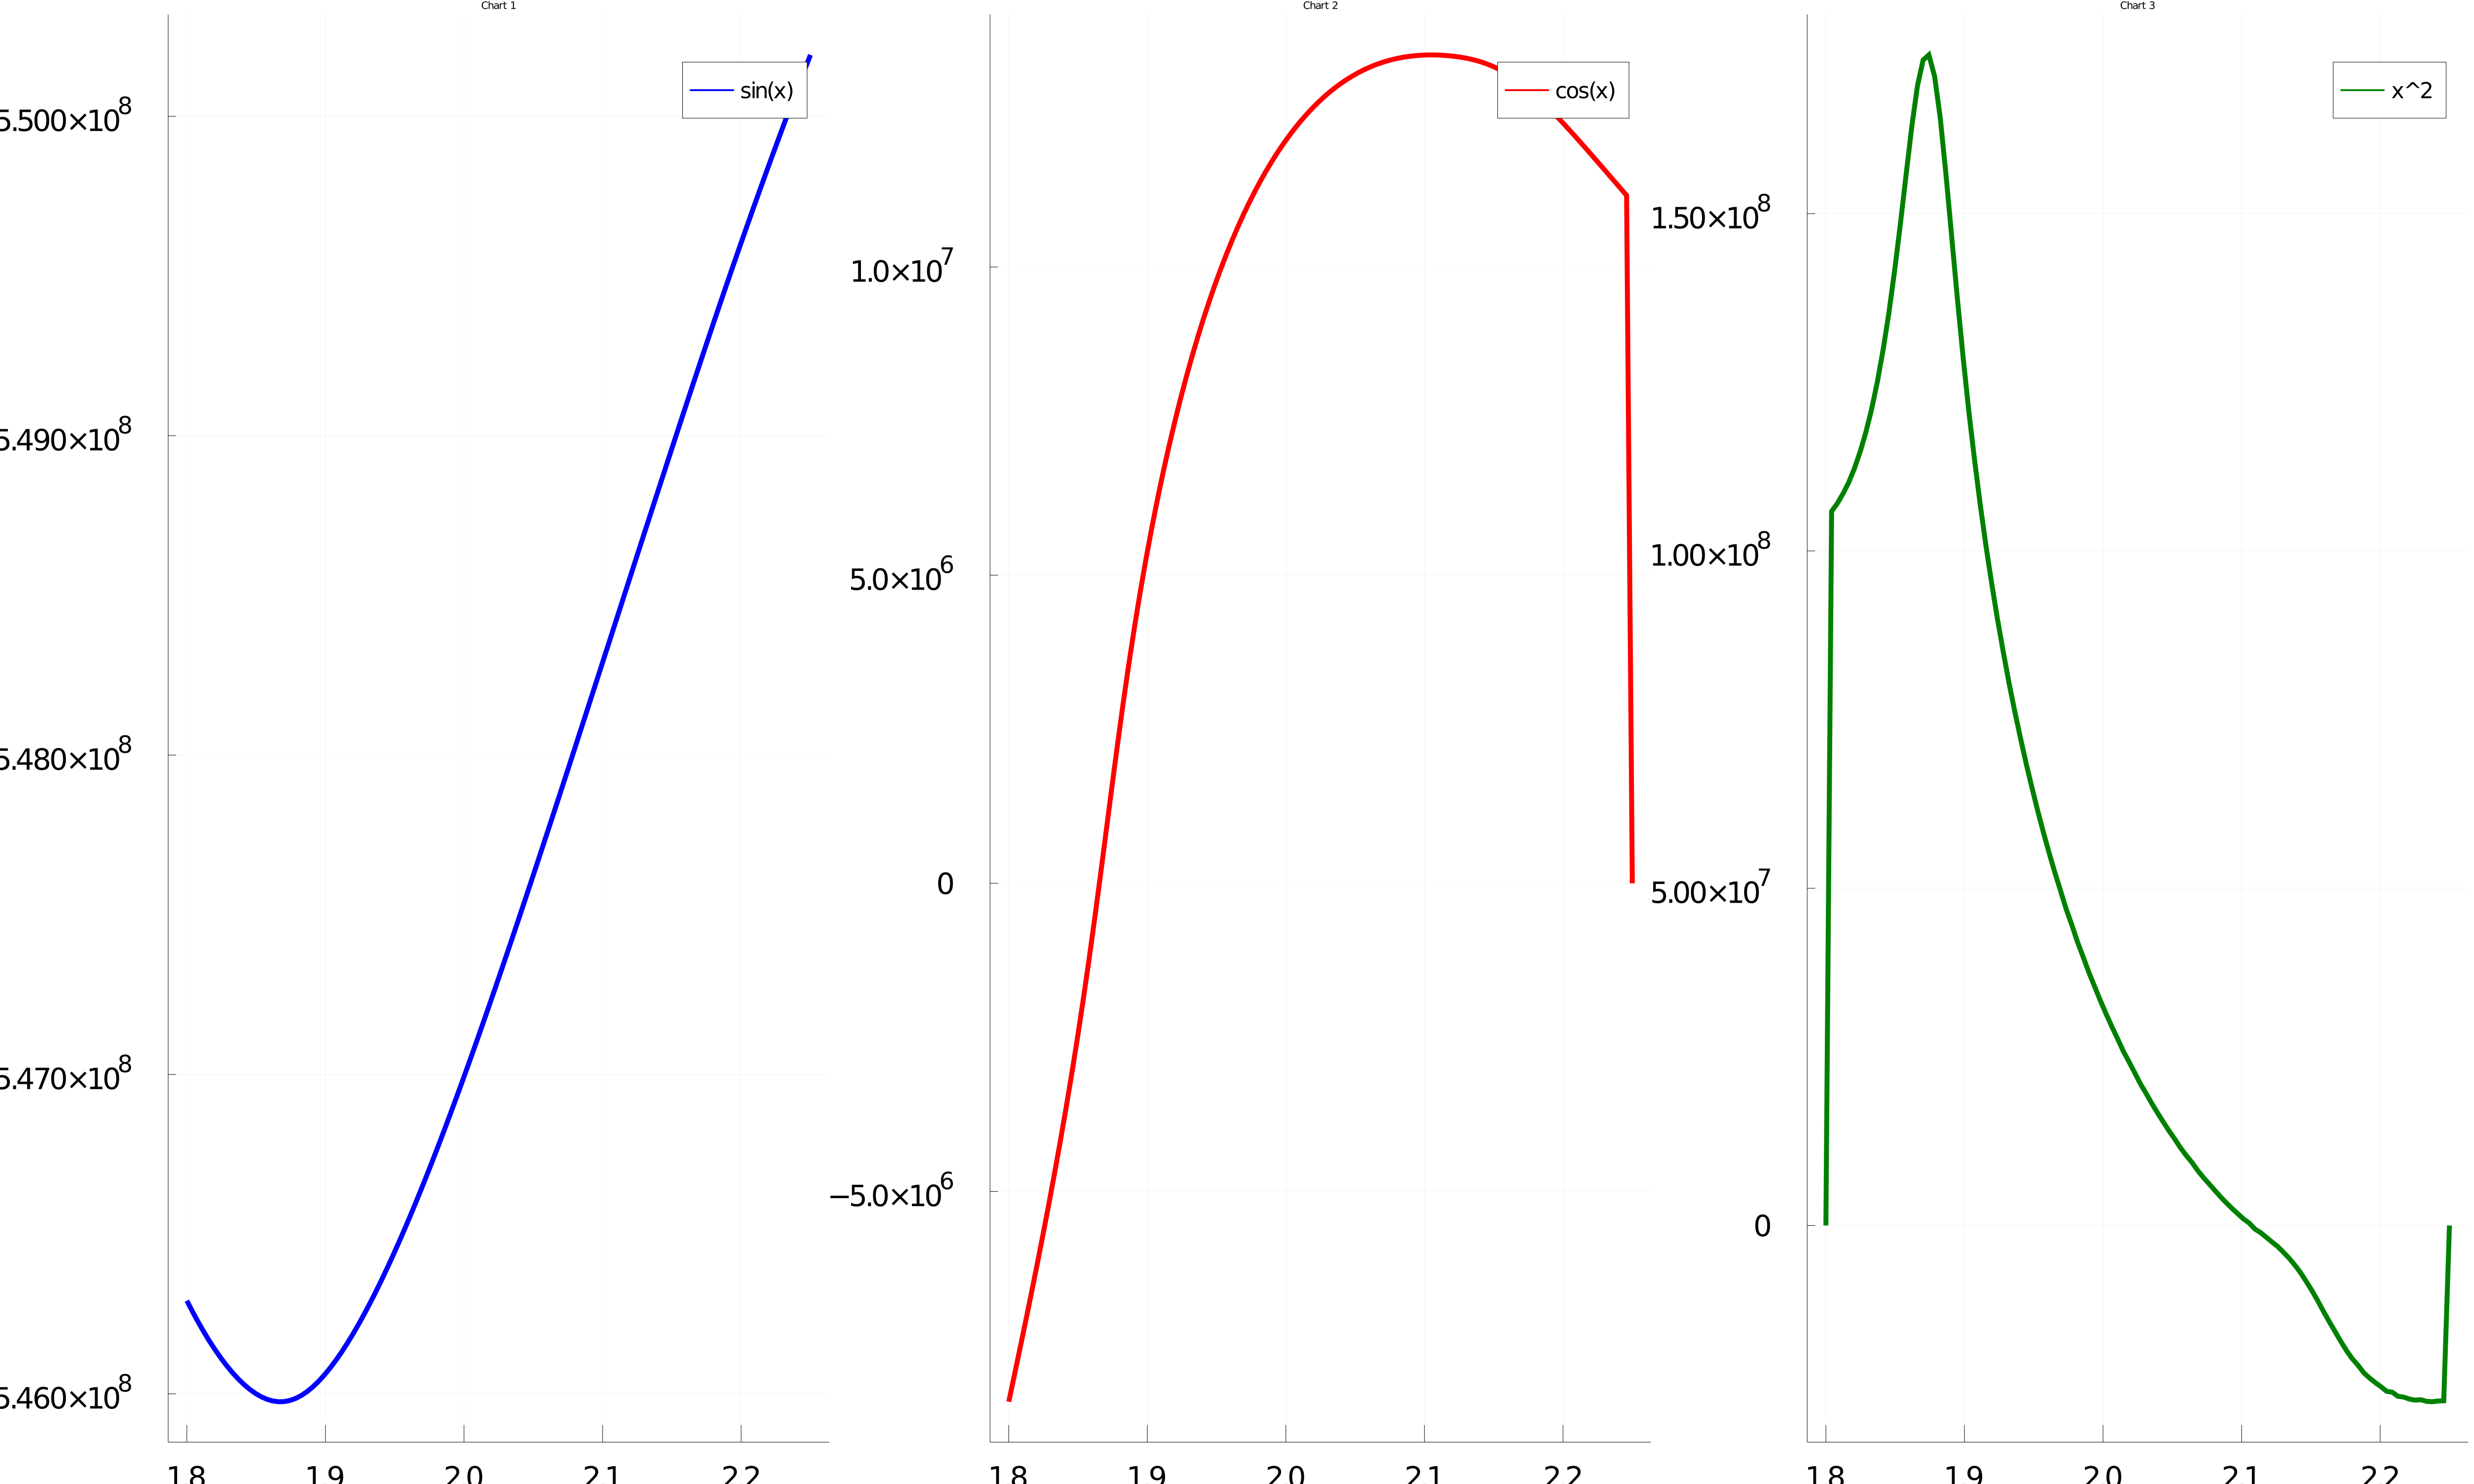

In [37]:
# Common plotting attributes
common_plot_attrs = Dict(
    :linewidth => 10,           # Line width
    :titlefontsize => 14,      # Title font size
    :legendfontsize => 30,     # Legend font size
    :tickfontsize => 40,       # Tick label font size
    :guidefontsize => 12       # Axis label font size
)

p1 = plot(Y_, energies_list
, label="sin(x)", title="Chart 1", color=:blue; common_plot_attrs...)

# Create the second plot
p2 = plot(Y_, first_list, label="cos(x)", title="Chart 2", color=:red; common_plot_attrs...)

# Create the third plot
p3 = plot(Y_, second_list, label="x^2", title="Chart 3", color=:green; common_plot_attrs...)

# Display the plots side by side
plot(p1, p2, p3, layout=(1, 3), size=(5000, 3000))

In [66]:
using DSP

function gaussian_kernel(len::Int, σ::Float64)::Vector{Float64}
    half_len = div(len, 2)
    x = -half_len:half_len
    g = exp.(-x.^2 / (2σ^2))
    return g ./ sum(g)  # Normalize the kernel so it sums to 1
end

function gaussian_smoothing(data::Vector{Float64}, σ::Float64)::Vector{Float64}
    len = 2*ceil(Int, 2*σ) + 1
    gaussian_filter = gaussian_kernel(len, σ)
    half_len = len ÷ 2
    smoothed = conv(data, gaussian_filter)[half_len+1:end-half_len]
    return smoothed
end

en = gaussian_smoothing(energies_list, 0.6)[2:end-1]
# Y_ = Y_[2:end-1]
first_ = first_derivative(en, Y_[2]-Y_[1])
second_ = second_derivative(en, Y_[2]-Y_[1])

18-element Vector{Float64}:
       0.0
      -4.349882831591327e8
 -649356.25350476
      -6.581414435585092e6
      -5.088863505882258e6
 -959277.5440803869
 -453834.61599433905
  520689.5428834017
  251804.8969942358
      -5.313347184551594e6
  767320.2726433359
      -1.4224682122213396e6
      -3.9646402411873764e6
 -949095.5737722617
       3.660476688963512e6
      -3.029319506291481e6
      -4.377648534043302e8
       0.0

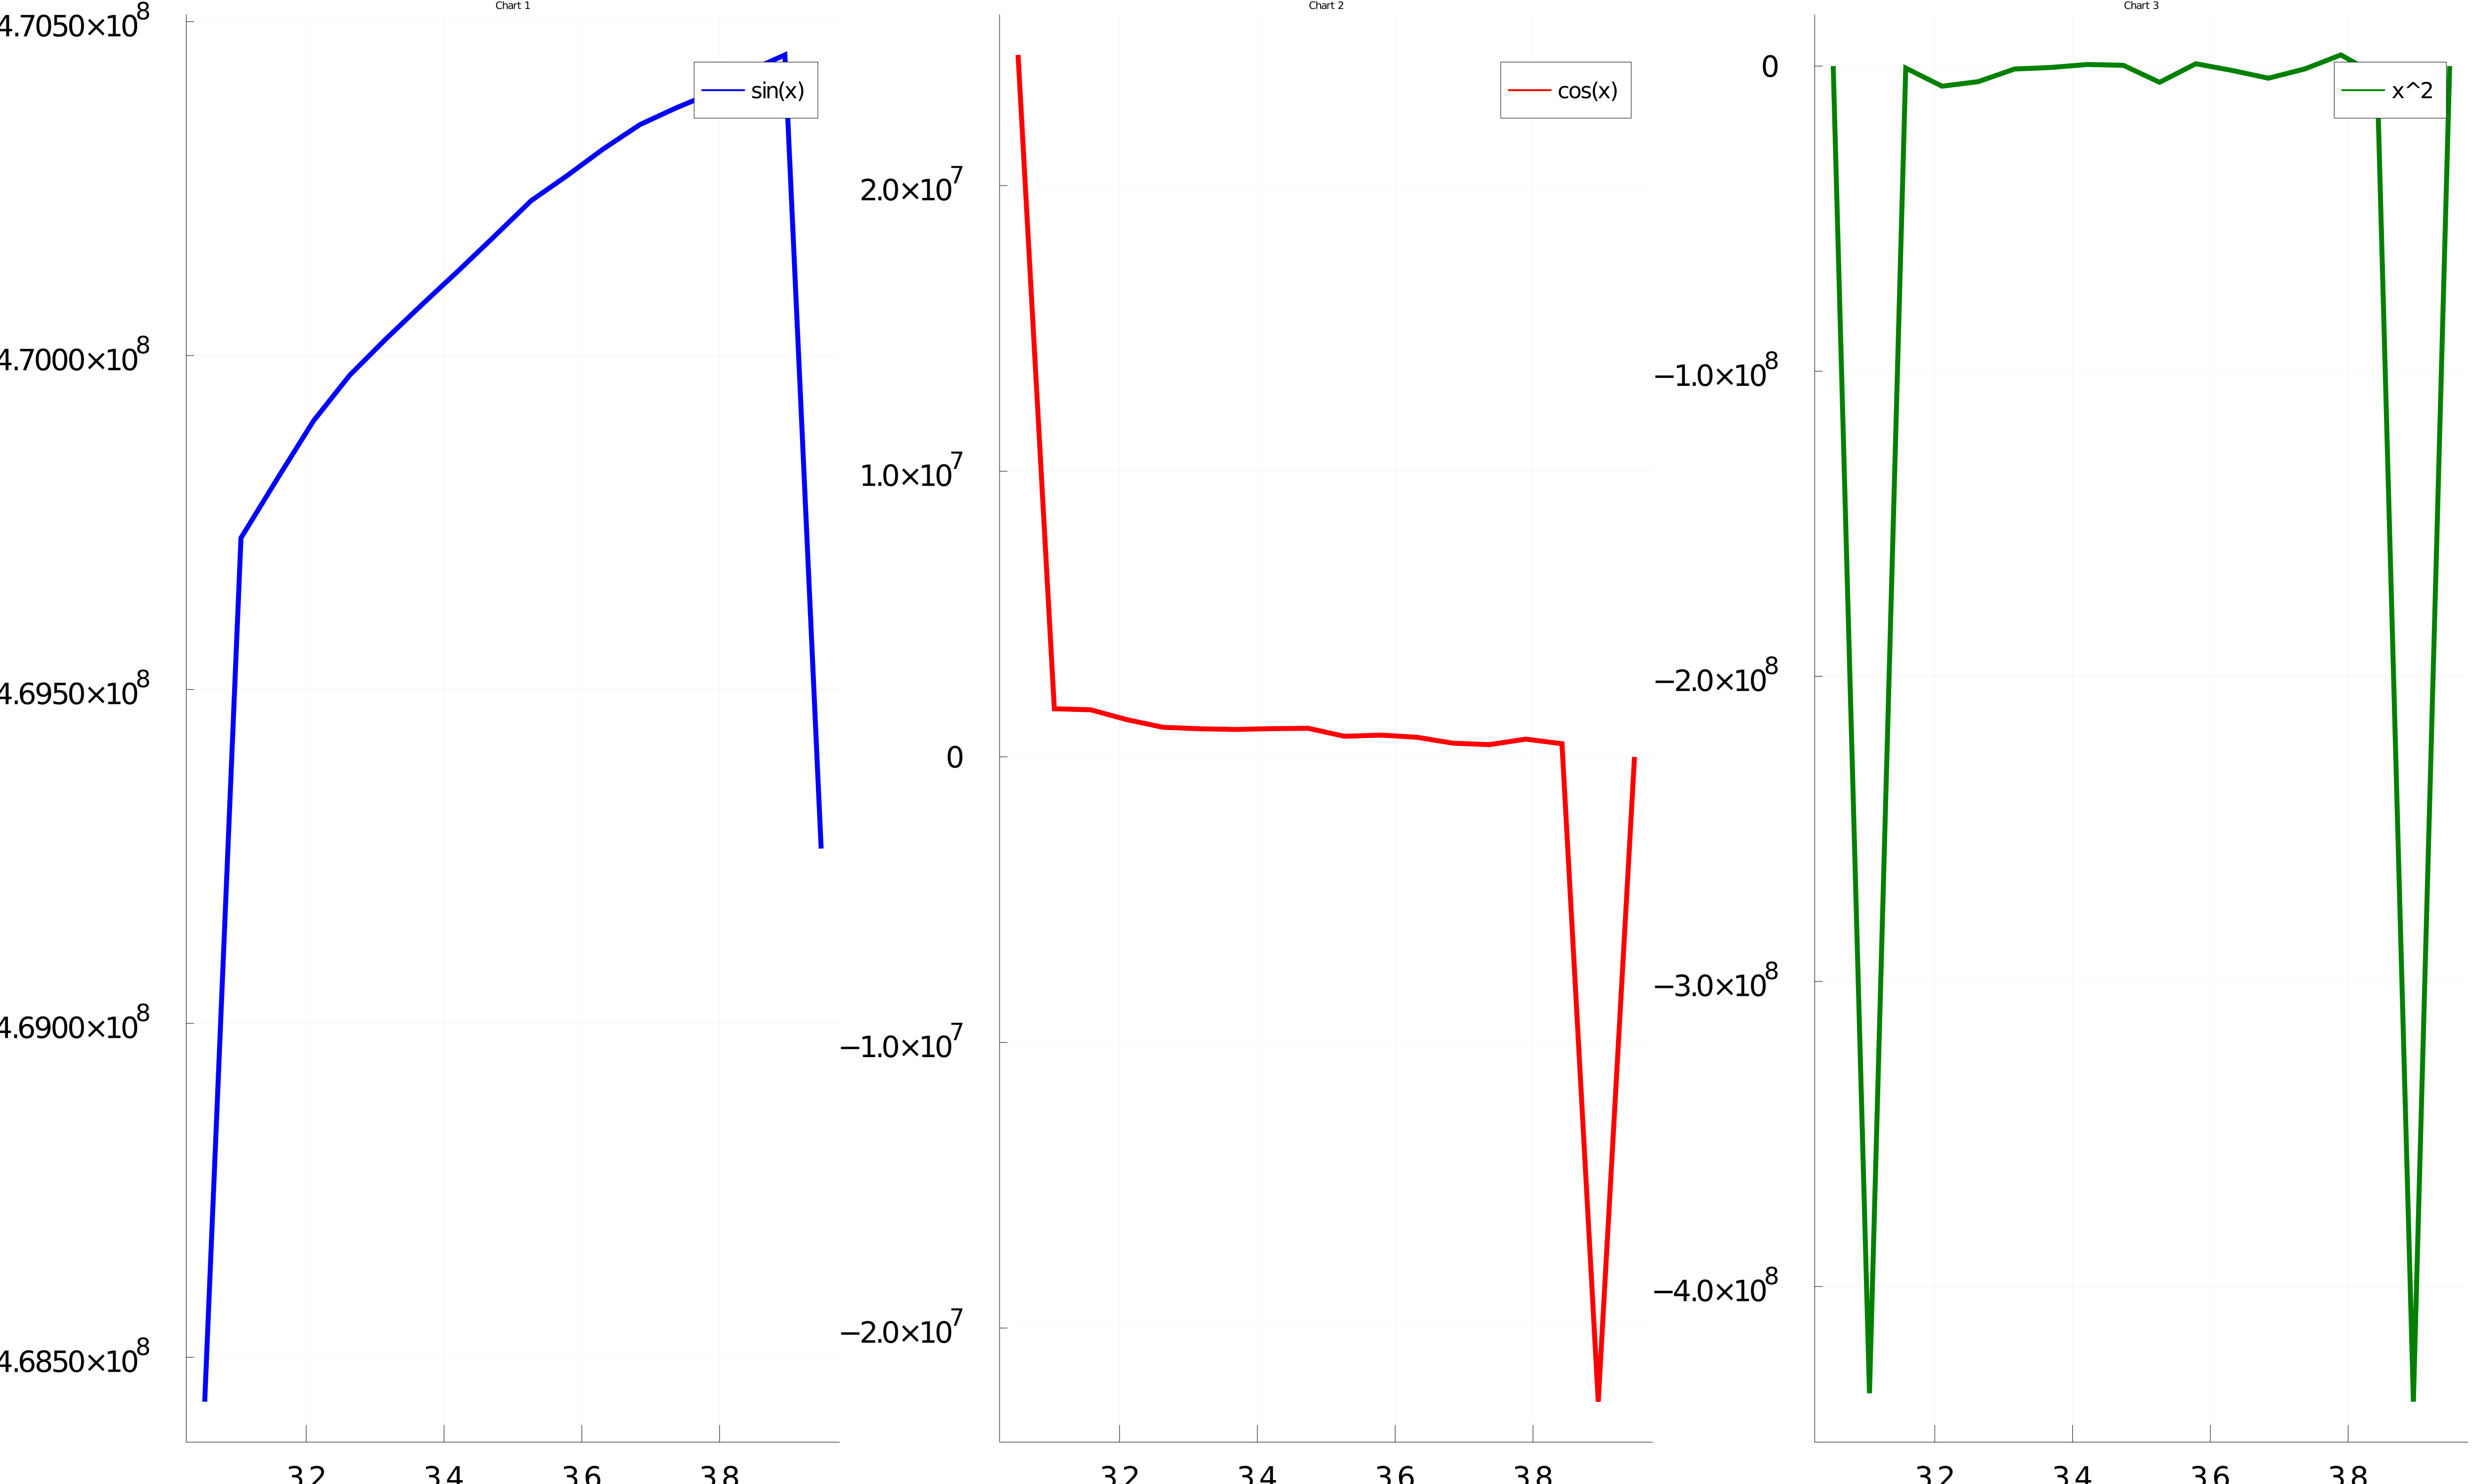

In [67]:
# Common plotting attributes
common_plot_attrs = Dict(
    :linewidth => 10,           # Line width
    :titlefontsize => 14,      # Title font size
    :legendfontsize => 30,     # Legend font size
    :tickfontsize => 40,       # Tick label font size
    :guidefontsize => 12       # Axis label font size
)

p1 = plot(Y_, en, label="sin(x)", title="Chart 1", color=:blue; common_plot_attrs...)

# Create the second plot
p2 = plot(Y_, first_, label="cos(x)", title="Chart 2", color=:red; common_plot_attrs...)

# Create the third plot
p3 = plot(Y_, second_, label="x^2", title="Chart 3", color=:green; common_plot_attrs...)

# Display the plots side by side
plot(p1, p2, p3, layout=(1, 3), size=(5000, 3000))

1


2


3


4


5


6


7


8


9


10


11


12


13


14


15


16


17


18


19


20


21


22


23


24


25


26


27


28


29


30


31


32


33


34


35


36


37


38


39


40


41


42


43


44


45


46


47


48


49


50


51


52


53


54


55


56


57


58


59


60


61


62


63


64


65


66


67


68


69


70


71


72


73


74


75


76


77


78


79


80


81


82


83


84


85


86


87


88


89


90


91


92


93


94


95


96


97


98


99


100


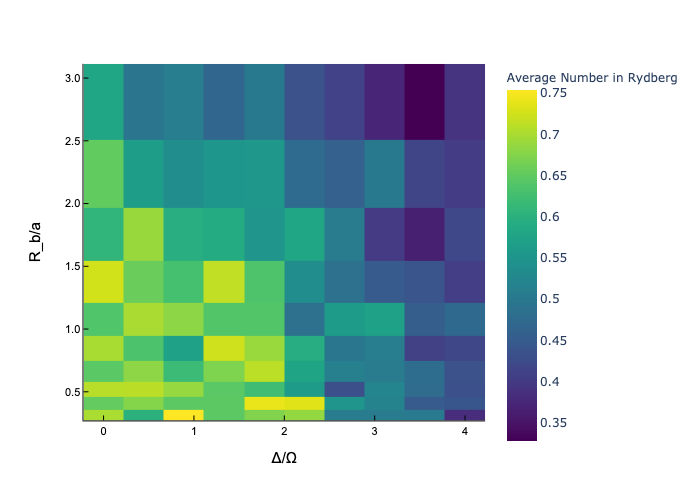

In [87]:
sites = siteinds("S=1/2", N)
psi0 = MPS(sites, ["Dn" for i = 1:N])
# psi0 = randomMPS(sites, 2)
plotlyjs()
plot(frequencies(9, 10, 0, -3.7, 2, 4, psi0, sites))